In [2]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import dataset,DataLoader
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch.nn.functional

In [3]:
class TempData(dataset.Dataset):
    def __init__(self,start_val=0,num_elements=1000,add_noise=True) -> None:
        super().__init__()
        self.start_val=start_val
        self.num_elements=num_elements
        self.add_noise=True
        if self.add_noise:
            rng=np.random.default_rng()
            self.randomFunc=lambda size:rng.uniform(0,1,size)
        else:
            self.randomFunc=lambda size:np.zeros(size)
        self.GenerateData()

    def GenerateData(self):
        self.true_data_celsius=np.arange(start=self.start_val,stop=self.start_val+self.num_elements).astype(np.double)
        # np.linspace(self.start_val,self.num_elements*self.step_size+self.start_val) # ground truth
        self.data=self.true_data_celsius*1.8+32.0+self.randomFunc(self.true_data_celsius.shape)
    
    def __getitem__(self, index):
        return self.data[index],self.true_data_celsius[index]
    
    def __len__(self):
        return self.num_elements

In [4]:
class Model(nn.Module):
    def __init__(self) -> None:
        super(Model,self).__init__()
        n_input=1
        n_output=1
        self.w=nn.Parameter(torch.randn(n_input,n_output))
        self.b=nn.Parameter(torch.randn(n_output))
    
    def forward(self,x):
        return x@self.w+self.b

In [5]:
def evaluate(mode,dataLoader,device="cpu"):
    model.eval()
    predictions=torch.FloatTensor(0)
    gt=torch.FloatTensor(0)

    for batch,(inputs,labels) in enumerate(testDataLoader):
        inputs=inputs.reshape(-1,1).to(device)
        labels=labels.reshape(-1,1).to(device)
        outputs=model(inputs)
        gt=torch.cat((gt,labels),0)
        predictions=torch.cat((predictions,outputs),0)
    mean_error=nn.functional.mse_loss(gt,predictions)
    return mean_error.detach().numpy()

In [6]:
trainDataLoader=DataLoader(TempData(start_val=0,num_elements=1000),batch_size=64,shuffle=True)
testDataLoader=DataLoader(TempData(start_val=1000,num_elements=300,add_noise=False),batch_size=64,shuffle=True)

In [7]:
model=Model().double()
optimizer=optim.Adam(model.parameters(),lr=0.1)
multiStepLR=optim.lr_scheduler.MultiStepLR(optimizer,milestones=[30,80],gamma=0.1)
loss=nn.MSELoss()
EPOCHES=100

In [8]:
device="cuda" if torch.cuda.is_available() else "cpu"
eval_epochs=20
error_train=[]
lr=[]
error_test=[]
for epoch in range(EPOCHES):
    model.train()
    total_error=0
    step=0
    for batch, (inputs,labels) in enumerate(trainDataLoader):
        step+=1
        inputs=inputs.reshape(-1,1).to(device)
        labels=labels.reshape(-1,1).to(device)
        optimizer.zero_grad() # Clear grad info
        outpus=model(inputs)
        loss_val=loss(outpus,labels)
        total_error+=loss_val.detach().numpy()
        loss_val.backward()
        optimizer.step()
    print("Epoch:%d/%d, lr %f"%(epoch,EPOCHES,multiStepLR.get_last_lr()[0]),end="\r")
    assert batch+1==step
    error_train.append([epoch,total_error/batch])
    lr.append([epoch,multiStepLR.get_last_lr()[0]])
    multiStepLR.step()
    if epoch % eval_epochs ==0:
        error_test.append([epoch,evaluate(model,testDataLoader,device=device)])

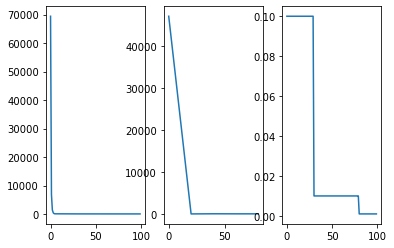

In [13]:
fig=plt.figure()
axes=np.array(fig.subplots(1,3)).flatten()
error_train=np.array(error_train).T
lr=np.array(lr).T
error_test=np.array(error_test).T
axes[0].plot(error_train[0],error_train[1])
axes[1].plot(error_test[0],error_test[1])
axes[2].plot(lr[0],lr[1])
# fig.tight_layout()